In [1]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

# Bayesian Network

**Prerequisites**

Some basic knowledge about [probabilities](../statistic/introduction.ipynb) and [conditional probabilities](../statistic/conditional_probability.ipynb).

## Motivation

Consider a jar with 2 coins.

One is a fair coin $(C_{50})$, and the other is a biased coin $(C_{90})$ with $Pr(H) = 0.9.
The agent does not know which coin we pick, but we do.

We pick one of the coin and start tossing.
Agent is tasked to figure out which coin we are holding.
Hence, the agent can refine its guess by the result of the coin toss.
Intuitively, if the result is a heads, then it is more likely for it to be the $C_{90}$, while if the results is tails, it is more likely to be the $C_{50}$.

Before tossing the coin, the agent's prediction would be:
$$P(C_{50}) = 0.5 \quad P(C_{90}) = 0.5$$

After tossing the coin, the agent's prediction would be:
$$P(C_{50} | \text{Result of Toss}) \quad P(C_{90} | \text{Result of Toss})$$

By [Bayes Theorem](../statistic/conditional_probability.ipynb#Bayes-theorem):

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

Assuming we got HHHTTT

$$P(C_{50} | HHHTTT) = \frac{0.5(0.5)^6}{0.5(0.5)^6 + 0.5(0.9)^3 (0.1^3)} \approx 0.9554$$

$$P(C_{90} | HHHTTT) = \frac{0.5(0.1)^3(0.9)^3}{0.5(0.5)^6 + 0.5(0.9)^3 (0.1^3)} \approx 0.04458$$

Hence, it is more likely for it to be the $C_{50}$, as per our intuition.

### Generalization

We have 2 models, and we want to determine which model explains the results better.
Notice that $(C_{50} |$ Result of Toss) and  $(C_{90} |$ Result of Toss) have the same denominator.
Thus, to compare the 2 probabilities, we only have to compare the numerator.

## Probability table

Assuming we are interested in grades, salary and birthdays of fresh graduates.

We discretize the variables as such:
* Grades: If the student graduated with honors
* Salary: If the student earns at least \$5000 a month
* Birthday: If the student is born in the months before July

We can do a survey to see the relationship between these factors.

Suppose that we obtain the following sample, from a sample size of 600

| Grades | Salary  | Birthday | Frequency  
| ---|---|---|---|
| T |T  |T  | 160  
| T | T | F |  60 
| T | F | T | 240  
| T | F | F |  40 
| F | T | T |  10 
| F | T | F |  60 
| F | F | T |  10 
| F | T | F |  20 

Hence, suppose that our agent saw a student who has high salary, then it is asked if the student had high grades.
The agent would be able to compute the probability using the table,  as follows:

$$P(G) = \frac{160+60+240+40}{600} = \frac{500}{600}$$

$$P(G|S) = \frac{60 + 160}{160+60+10+60}$$

### Problems

For a small improvement, we can remove the last entry as we can derive the last entry by $1 - \sum _{e \in\text{all other entries}}Pr(e)$

Hence, we get the representation below:

| Grades | Salary  | Birthday | Frequency  
| ---|---|---|---|
| T |T  |T  | 160/600  
| T | T | F |  60/600 
| T | F | T | 240/600  
| T | F | F |  40/600 
| F | T | T |  10/600 
| F | T | F |  60/600 
| F | F | T |  10/600 

However, the table size is still $2^n$, exponential to number of variables. 

## Bayesian Network

Suppose we have 5 (boolean) variables instead, and are looking at the outcome of a fresh graduate at an interview: 
* Grades: $G$
* Salary: $S$
* Performance in interview: $I$
* Mood of candidate: $M$
* Amount of tip given to others: $T$

We can theorize a few relationship between the variables, such as:
* $S$ is dependent on $I$
* $I$ is dependent on $G$ and $M$
* $I$ is not dependent on $T$
* *etc*

We can represent the dependency of the variables as a graph.

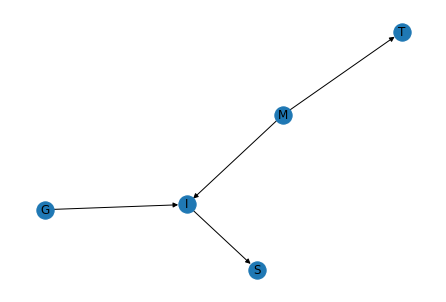

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edge("I", "S")
G.add_edge("G", "I")
G.add_edge("M", "I")
G.add_edge("M", "T")
nx.draw(G, with_labels=True)
plt.show()

We call this network **Bayesian Network/Belief Network/Inference Network**.

With this, we can make a more compressed table.

For example, between $G$, $M$ and $I$

| $$G$$ | $$M$$  | $$P(I | G, M)$$ | 
| --- | --- | --- |
| T |T  | 160/220 | 
| T | F |  240/280 | 
| F | T |   10/70| 
| F | F |  20/30| 

Note that the sum of the right column may not be 1, since this is conditional probabilities.

Also, we have omitted the probabilities related to $P(I = F | \cdot)$, since they can be derived from $P(I | \cdot)$, which also saves many entries in our table.

Assume that the maximum number of parents that any nodes have in our graph is $q$.

We would have at most $2^q$ entries per table. 
Thus there are at most $2^q \times n$ entries overall.

For our example, we will need 10 entries. (1 for $G, M$; 2 for $T, S$ and 4 for $I$).
This is much better than the $2^5 -1 = 31$ entries that we need previously. 

### Theorem

Each node in a network is independent of its non-descendents, given its parents.

### Examples

$P(I| G,M,T) = P(I| G, M)$, as T is a non-descendant and $G$ and $M$ are parents.

$P(T| M, G) = P(T| M)$

$P(I | S, T, M) = P(I, S, T, M) / P(S, T ,M)$ may not = $P(I | G, M)$ as S is a child of I

### Chain rule

$$P(a,b,c,d,e) = P(a|b,c,d,e) P(b|c,d,e) \dots P(e)$$

## Reordering the variable

Reordering variables may make it easier to factor.

For example, it is difficult to solve $P(G, I, S, M, T)$ directly, since $S$ is not a parent of $I$.

But we can perform the below

$$
\begin{align}
P(G, I, S, M, T) &= P(S, I, G ,T ,M) \\
&= P(S | I,G,T,M) \times P(I| G, T, M) \times P(G | T,M) \times P(T| M) \times P(M) \\
&=  P(S | I) \times P(I| G, M) \times P(G) \times P(T| M) \times P(M) \\
\end{align}
$$

Thus, at each step, we want each probability $P(A| X_i)$ such that $X_i$ are not descendant of A

Since this is a directly acyclic graph, we can recursively choose nodes without children and remove them.